In [8]:
library(broom)
library(tidyr)
library(plyr)
library(dplyr)
library(pscl)
library(ROCR)
#library(car)
library(foreign)
library(gplots)
options(tibble.print_max = Inf)

In [17]:
input <- read.csv(file = "input0_hypo.csv", sep=",")

In [18]:
smp_size <- floor(0.66 * nrow(input))
      
      ## set the seed to make your partition reproducible
      #set.seed(123)
train_ind <- sample(seq_len(nrow(input)), size = smp_size)
train <- input[train_ind, ]
test <- input[-train_ind, ]

In [19]:
ConjVazio = glm(TARGET ~1, family = binomial(logit), data = train)
ConjCheio = glm(TARGET ~., family = binomial(logit), data = train) 
StepModel <- step(ConjVazio, scope =list(lower=ConjVazio, upper=ConjCheio),direction = "both") 

Start:  AIC=10588.56
TARGET ~ 1

               Df Deviance     AIC
+ Q001          1   8872.9  8876.9
+ Q002          1   9133.6  9137.6
+ QT_TITULACAO  1  10504.4 10508.4
<none>             10586.6 10588.6

Step:  AIC=8876.94
TARGET ~ Q001

               Df Deviance     AIC
+ Q002          1   8655.0  8661.0
+ QT_TITULACAO  1   8833.5  8839.5
<none>              8872.9  8876.9
- Q001          1  10586.6 10588.6

Step:  AIC=8660.96
TARGET ~ Q001 + Q002

               Df Deviance    AIC
+ QT_TITULACAO  1   8616.9 8624.9
<none>              8655.0 8661.0
- Q002          1   8872.9 8876.9
- Q001          1   9133.6 9137.6

Step:  AIC=8624.88
TARGET ~ Q001 + Q002 + QT_TITULACAO

               Df Deviance    AIC
<none>              8616.9 8624.9
- QT_TITULACAO  1   8655.0 8661.0
- Q002          1   8833.5 8839.5
- Q001          1   9081.3 9087.3


In [20]:
df<- tidy(StepModel)
      
      #Ordena coeficientes e filtra p-value nivel 0.05
      df<-arrange(df, desc(estimate))
      df<-filter(df, p.value < 0.05)
      #Coleta 6 principais negativos e 6 principais positivos
      main_positivas<-head(df, n=6)
      main_negativas<-tail(df, n=6)
      
      #Preparacao base de Testes para avaliação
      #filtro teste apenas com variáveis selecionadas pelo Step
      df1<-tidy(anova(StepModel))
      #extrai a coluna com nomes das colunas importantes para um vetor
      df1<-df1 %>% pull(term)
      #Retira primeira linha com valor NULL
      df1<-df1[-(1)]
      #Separa alvo dos demais
      Alvo<-select(test, TARGET)
      #Cria nova base testes apenas com colunas importantes (Alvo fica fora, porem foi guardado no passo anterior)
      test2<-test %>% select(df1)
      #Combina novamente Alvo ao teste filtrado
      test2<- cbind(test2, Alvo)

Warning message in tidy.anova(anova(StepModel)):
“The following column names in ANOVA output were not recognized or transformed: Deviance, Resid..Df, Resid..Dev”


In [21]:
#Avaliacao
      PredicaoResp <- predict(StepModel, newdata = test2, type = "response")
      PredicaoClass <- ifelse(PredicaoResp > 0.5,1,0)
      MisClasificError <- mean(PredicaoClass !=test2$TARGET)
      acc<- 1-MisClasificError
      pr <- prediction(PredicaoResp, test2$TARGET)
      prf <- performance(pr, measure = "tpr", x.measure = "fpr") 
      #Area under Roc Curve
      auc <- performance(pr, measure = "auc")
      auc <- auc@y.values[[1]] 

[1] 0.7909575

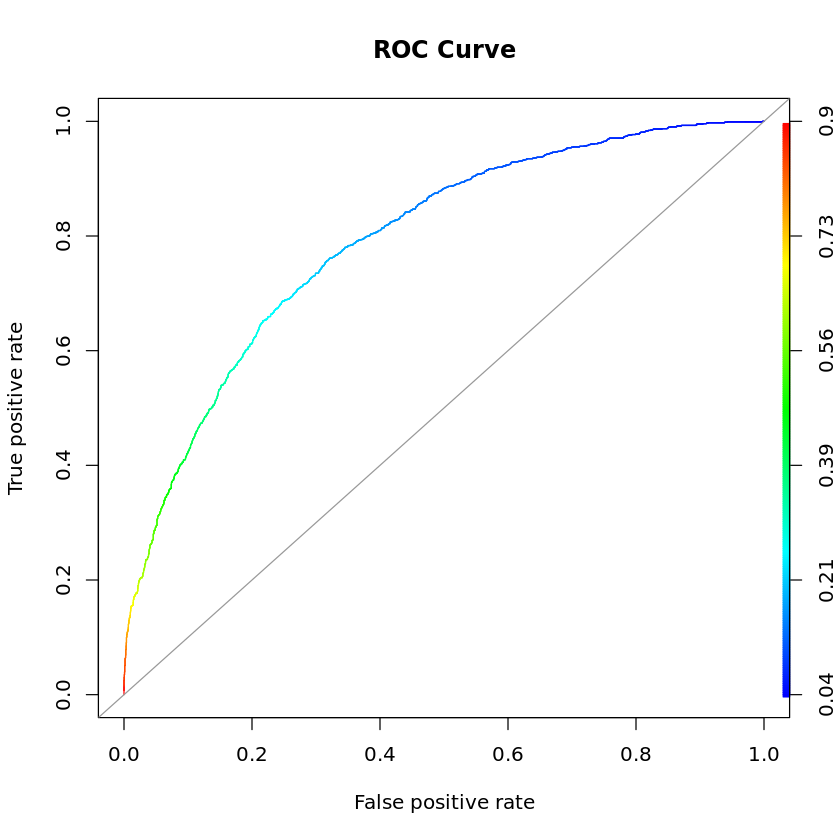

In [22]:
#Plota Grafico ROC
plot(prf, main = "ROC Curve", colorize=T)
abline(a=0, b=1, col = "gray60")
auc

In [23]:
main_negativas
main_positivas


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Q001,3.865129,0.1827690,21.147612,2.902673e-99
Q002,2.937960,0.1989167,14.769799,2.293960e-49
QT_TITULACAO,2.622525,0.4205327,6.236199,4.483313e-10
(Intercept),-3.645434,0.1180302,-30.885602,1.864398e-209


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Q001,3.865129,0.1827690,21.147612,2.902673e-99
Q002,2.937960,0.1989167,14.769799,2.293960e-49
QT_TITULACAO,2.622525,0.4205327,6.236199,4.483313e-10
(Intercept),-3.645434,0.1180302,-30.885602,1.864398e-209


In [24]:
StepModel


Call:  glm(formula = TARGET ~ Q001 + Q002 + QT_TITULACAO, family = binomial(logit), 
    data = train)

Coefficients:
 (Intercept)          Q001          Q002  QT_TITULACAO  
      -3.645         3.865         2.938         2.623  

Degrees of Freedom: 9487 Total (i.e. Null);  9484 Residual
Null Deviance:	    10590 
Residual Deviance: 8617 	AIC: 8625